# Predicting Customer Churn

Matt Williams

03/30/2025

Determining why some customers stay with a product or service and why they leave is an interesting business question. In this project, I test several machine learning classification algorithms to get an idea of which one performs best on this [Customer Churn Dataset on Kaggle](https://www.kaggle.com/datasets/hassanamin/customer-churn). The dataset is from a hypothetical marketing agency that serves ads to customers with multiple websites.

## 1.0 Introduction

### 1.1 Initialize a Python Environment

In [37]:
import pandas as pd
import numpy as np

from scipy.stats import zscore
from scipy import stats
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import datetime
import seaborn as sns

### 1.2 Read & Preprocess Dataset

The data can now be read into memory using pandas. Here the date is also converted from a text string to a time stamp in case its needed later on.

In [63]:
# Read customer churn data from csv file
df = pd.read_csv('customer_churn.csv')

# Convert Onboard_date from text data type to date/time
df['Onboard_date'] = pd.to_datetime(df['Onboard_date'], format='%Y-%m-%d %H:%M:%S')

# Create a list of attributes to include in the analyses
attributes = ['Age', 'Total_Purchase', 'Years', 'Num_Sites']

# Preview the Data
df.head()

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


In [64]:
# View general statistics of numeric data
df.describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Churn
count,900.000000,900.000000,900.000000,900.000000,900.000000,900,900.000000
mean,41.816667,10062.824033,0.481111,5.273156,8.587778,2011-04-11 15:50:48.358888960,0.166667
min,22.000000,100.000000,0.000000,1.000000,3.000000,2006-01-02 04:16:13,0.000000
25%,38.000000,8497.122500,0.000000,4.450000,7.000000,2008-05-29 16:43:21.249999872,0.000000
50%,42.000000,10045.870000,0.000000,5.215000,8.000000,2011-03-09 04:36:26.500000,0.000000
75%,46.000000,11760.105000,1.000000,6.110000,10.000000,2014-02-15 00:01:16.249999872,0.000000
max,65.000000,18026.010000,1.000000,9.150000,14.000000,2016-12-28 04:07:38,1.000000
std,6.127560,2408.644532,0.499921,1.274449,1.764836,NaN,0.372885


It's always important to look for 'nan' values and outliers. 

In [65]:
# Look for 'nan' values per attribute
df.isna().sum()

Names              0
Age                0
Total_Purchase     0
Account_Manager    0
Years              0
Num_Sites          0
Onboard_date       0
Location           0
Company            0
Churn              0
dtype: int64

Luckily, there are no 'nan' values in the dataset. Next, we'll look for outliers. To do this, z_scores are calculated for each data point in the attributes we're interested in. A z_score is the number of standard deviations a given data point is from the mean. Z_scores above 3 are dropped from the dataset.

In [71]:
# Look for outliers
print('Number of z_scores > 3.0')
print('------------------------')
z_scores = df[attributes].apply(zscore)
z_scores[z_scores > 3].count()

Number of z_scores > 3.0
------------------------


Age               1
Total_Purchase    1
Years             1
Num_Sites         6
dtype: int64

Now, let's drop records with z_scores higher than 3 as outliers.

In [73]:
df = df[(np.abs(stats.zscore(df[attributes]))<3).all(axis=1)]

print('Number of z_scores > 3.0')
print('------------------------')
z_scores = df[attributes].apply(zscore)
z_scores[z_scores > 3.0].count()

Number of z_scores > 3.0
------------------------


Age               0
Total_Purchase    0
Years             0
Num_Sites         0
dtype: int64

In [74]:
df.describe()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Churn
count,886.000000,886.000000,886.000000,886.000000,886.000000,886,886.000000
mean,41.817156,10059.226445,0.480813,5.271659,8.569977,2011-04-12 09:09:45.476297984,0.163657
min,25.000000,3263.000000,0.000000,1.580000,4.000000,2006-01-02 04:16:13,0.000000
25%,38.000000,8486.327500,0.000000,4.450000,7.000000,2008-05-28 18:58:55.750000128,0.000000
50%,42.000000,10022.130000,0.000000,5.210000,8.000000,2011-03-09 04:36:26.500000,0.000000
75%,46.000000,11762.935000,1.000000,6.102500,10.000000,2014-02-15 18:43:20.750000128,0.000000
max,60.000000,16955.760000,1.000000,8.970000,13.000000,2016-12-28 04:07:38,1.000000
std,6.068198,2381.787024,0.499914,1.263932,1.693844,NaN,0.370173


### 1.3 Check for Colinearity

Colinearity is when attributes are linearly correlated to one another. Machine learning algorithms are used to determine the relationship of each attribute (independent variable) to the dependent variable. Any input variables that are correlated with one another are not independent and should be dealt with. The code block below creates and displays a correlation matrix to assess whether there is any colinearity among the attributes.

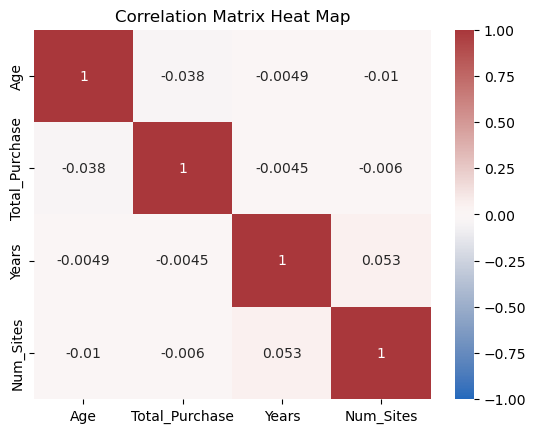

In [75]:
# Create the correlation matrix
matrix = df[attributes].corr(
    method = 'pearson')

# Plot correlation matrix & color by coefficient values
sns.heatmap(matrix, annot=True,
           vmax = 1,
           vmin = -1,
           center = 0,
           cmap = 'vlag');
plt.title('Correlation Matrix Heat Map');

The matrix above shows very little correlation among the attributes we've chosen for this analysis. As such, we do not need to do any feature reduction.

## 2.0 Split Data for Training & Testing

Using train_test_split from the scikit-learn library, split the data using 80% for training and 20% for testing.

In [44]:
# Create 'X'attribute inputs and 'y' labels
X = df[attributes]
y = df['Churn']

# Split attributes and labels into training & testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Create a dictionary to store model scores
results_dict = {}

One of the machine learning algorithms we plan to use is k-Nearest Neighbors. This algorithm performs best with data that has been scaled. Here, I am creating a copy of the testing and training data that has been scaled for use in the kNN algorithm.

In [76]:
# Scale the data for models that require it
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3.0 Create & Compare Machine Learning Models to Predict Customer Churn

### 3.1 Training & Testing Models

Here, I am initializing, training, and testing the following models on the customer churn data:

1. Decision Trees
2. Random Forest
3. Linear Regression
4. Logistic Regression
5. k-Nearest Neighbors
6. Multilayer Perceptron (MLP/Neural Network)

For the most part, the models were used with the defaults. Again, the aim of this project was to develop a script that could readily take a dataset and perform basic classification analyses for the purposes of seeing which algorithm performs best. From here, the best performing models could be developed further and tuned to maximize their accuracy.

In [81]:
# 1. Decision Tree Model
decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, y_train)
results_dict['Decision Tree'] = round(decision_tree.score(X_test, y_test),2)

# 2. Random Forest Model
random_forest = rfc(n_estimators = 100, max_depth=3, random_state=0)
random_forest.fit(X_train,y_train)
results_dict['Random Forest'] = round(random_forest.score(X_test, y_test), 2)

# 3. Linear Regression
linear_model = LinearRegression()
linear_model = LinearRegression(fit_intercept = True).fit(X_train, y_train)
results_dict['Linear Regression'] = round(linear_model.score(X_test, y_test),2)

# 4. Logistic Regression
log_model = LogisticRegression(fit_intercept = True,
                              max_iter=200).fit(X_train, y_train)
results_dict['Logistic Regression'] = round(log_model.score(X_test, y_test),2)

# 5. k-Nearest Neighbors Regression
neighbors = []                                        # an empty list to store values for k
knn_score = []                                        # an empty list to store model scores
for i in range(1, 21, 1):                             # loop through k values
    knn = KNeighborsRegressor(n_neighbors = i)        # initialize the model
    knn = knn.fit(X_train_scaled, y_train)            # train the model
    knn_score.append(knn.score(X_test_scaled,y_test)) # calculate & store test score data
    neighbors.append(i)                               # store k value
max_index = knn_score.index(max(knn_score))           # find index of max model score
k = neighbors[max_index]                              # look up corresponding k value
results_dict['kNN Model'] = round(max(knn_score),2)

# 6. Multilayer Perceptron
mlp_model = MLPClassifier(random_state=0,
                          max_iter=300,
                          activation = 'relu',
                          hidden_layer_sizes=(10,10)
                         ).fit(X_train, y_train)
results_dict['MLP Model'] = round(mlp_model.score(X_test, y_test),2)

# Results Summary

With each of the machine learning models trained and tested, let's look at the results.

In [90]:
print('\n{:20s} {:>10s}'.format('Model', 'Score'))  # print header
print(31*'-')                                       # underline headers
for i in results_dict:                              # loop through results_dict to print models & scores
        print('{:20s} {:>10.2f}'.format(i, results_dict[i]))

# Print the name of the best performing model
print('\nThe best model for predicting customer churn is the', max(results_dict, key=results_dict.get)+'.')


Model                     Score
-------------------------------
Decision Tree              0.94
Random Forest              0.91
Linear Regression          0.32
Logistic Regression        0.92
kNN Model                  0.46
MLP Model                  0.83

The best model for predicting customer churn is the Decision Tree.


The decision tree model performed best, however, they are also susceptible to over fitting. As a data scientist looking at the scores above, I would be more apt to further develop the logistic regression or the random forest.

# Decision Tree Plot

Let's have a look at the decision tree to see what we can learn about customers who are more likely to leave.

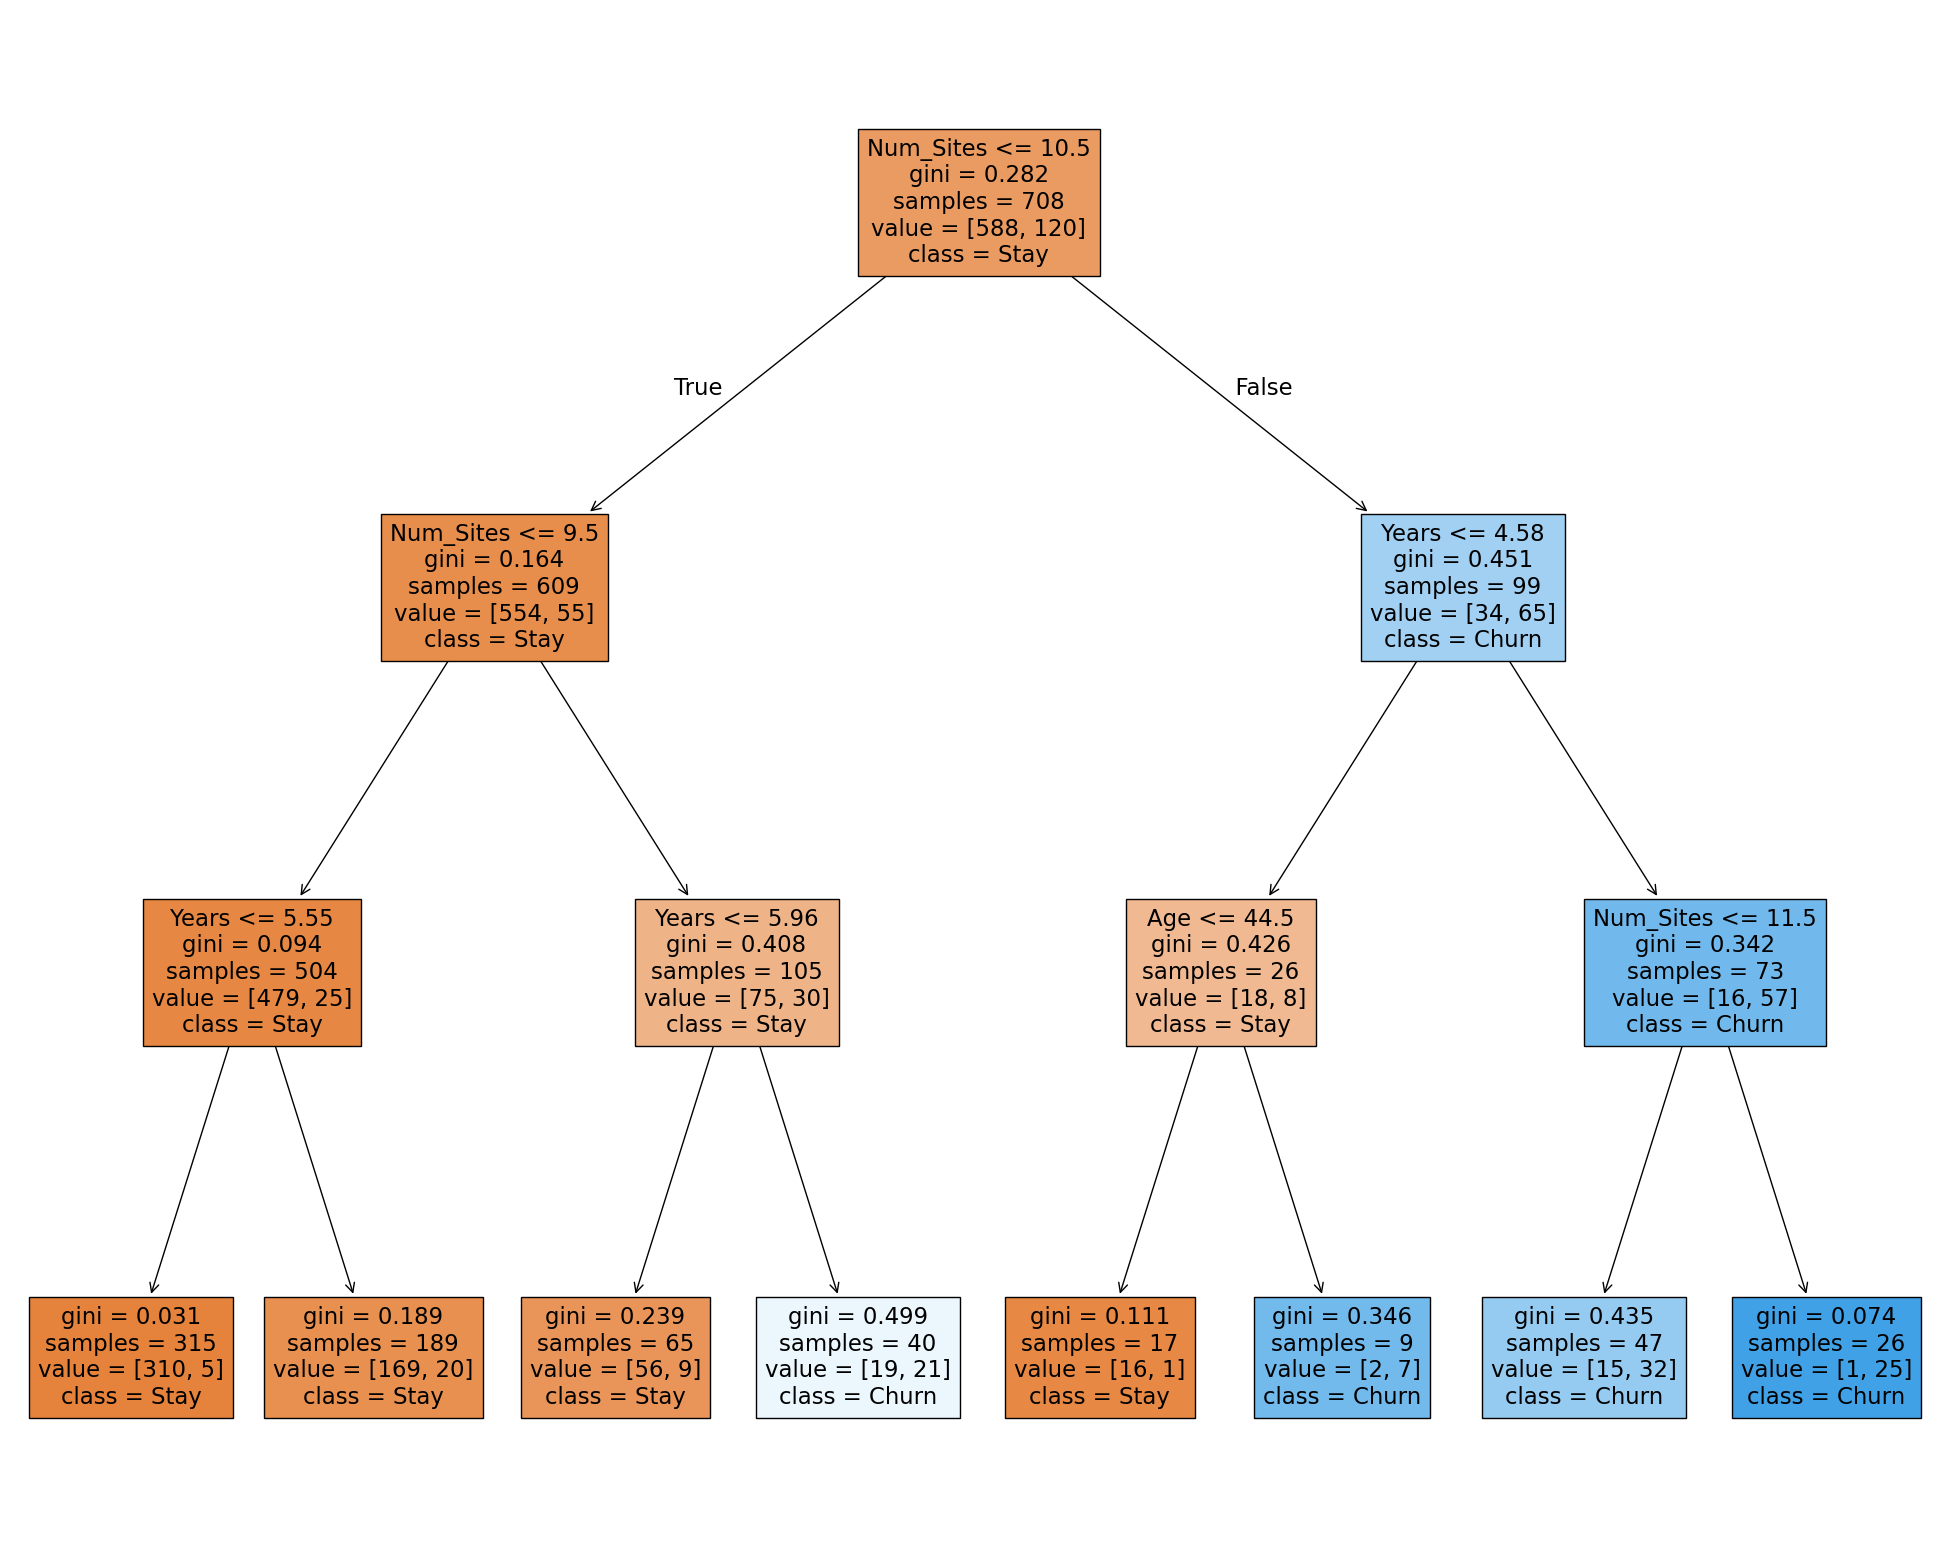

In [13]:
# Plot the decision tree
fig = plt.figure(figsize = (25,20))
_ = tree.plot_tree(decision_tree, feature_names = attributes, class_names=['Stay', 'Churn'], filled=True)

The tree above highlights two things. First, only 6.5% of customers with fewer than 10.5 websites leave the service. Second, 74% of the 99 customers with more than 10.5 websites end up leaving the service (more so if they have been there longer than 4.58 years). We can't say for sure why they are leaving but my best guess is that the platform may not have the tools they need to manage ads on large numbers of websites.

Another possibility is that customers with more than 10.5 websites may not be getting the attention they need. This we can look at by determining the percentage of customers in both groups (those that have more and less than 10.5 websites) that have an account manager.

In [107]:
print('Percentage of customers with...')
print('\tmore than 10.5 websites with an account manager: ', end='')
print(round(df[df['Num_Sites'] > 10.5]['Account_Manager'].sum()/len(df[df['Num_Sites'] > 10.5]),2)*100,'%')

print('\tless than 10.5 websites with an account manager: ', end='')
print(round(df[df['Num_Sites'] < 10.5]['Account_Manager'].sum()/len(df[df['Num_Sites'] < 10.5]),2)*100,'%')

Percentage of customers with...
	more than 10.5 websites with an account manager: 47.0 %
	less than 10.5 websites with an account manager: 48.0 %


Both groups have a similar percentage of customers with an account manager so it's hard to say whether or not customers with more han 10.5 websites would benefit from having an account manager.

My advice to this marketing firm would be to talk to their customers that have more than 10 websites to see what it is they need. Do they need different tools to manage the number of websites they have? Would they be interested in a higher tier of service that caters to larger customers in some way?

Taking the time to understand these customers and make them feel heard could go a long way toward retaining them.